# LightGBM 모델 튜닝

1. features_train.csv, features_test.csv를 로드   
2. 07_train_eval.py와 동일한 방식으로 피처를 구성    
3. 여러 LightGBM 하이퍼파라미터 조합을 실험  
4. MAE / MAPE / SMAPE 기준으로 가장 좋은 조합을 찾기

In [6]:
from pathlib import Path

import numpy as np
import pandas as pd
from lightgbm import LGBMRegressor, early_stopping, log_evaluation
from sklearn.metrics import mean_absolute_error

import matplotlib.pyplot as plt


BASE = Path("../data_pipeline").resolve()
print("DATA DIR:", BASE)

TR = BASE / "features_train.csv"
TE = BASE / "features_test.csv"

train = pd.read_csv(TR, parse_dates=["target_date"])
test  = pd.read_csv(TE, parse_dates=["target_date"])

print("train shape:", train.shape)
print("test shape:", test.shape)

train.head()


DATA DIR: C:\Users\chosw\ORDER101_SMART_ORDERRR\be18-fin-SYNERGY-ORDER101\python-server\app\data_pipeline
train shape: (266500, 43)
test shape: (33800, 43)


,target_date,warehouse_id,store_id,sku_id,region,cat_low,actual_order_qty,lag_1,lag_2,lag_4,...,back_to_school,avg_temp_c_ma4,cdd_ma4,hdd_ma4,precip_mm_ma4,himart_sales_index_ma4,holiday_index_ma4,marketing_score_ma4,y,split
0,2016-02-29,1,1,AC-CAR-16P-2024,본사창고,에어컨,60,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60.0,train
1,2016-03-07,1,1,AC-CAR-16P-2024,본사창고,에어컨,0,60.0,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,train
2,2016-03-14,1,1,AC-CAR-16P-2024,본사창고,에어컨,0,0.0,60.0,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,train
3,2016-03-21,1,1,AC-CAR-16P-2024,본사창고,에어컨,0,0.0,0.0,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,train
4,2016-03-28,1,1,AC-CAR-16P-2024,본사창고,에어컨,0,0.0,0.0,60.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,train


## 1. 평가 지표 & 헬퍼 함수 정의

In [16]:
ID_KEYS = ["warehouse_id", "store_id", "sku_id", "region", "target_date", "split"]
TARGET = "y"

LEAKY = {"actual_order_qty", "share_norm", "promo_flag"}


def smape(y_true, y_pred):
    """Symmetric MAPE(%)"""
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    denom = (np.abs(y_true) + np.abs(y_pred)) / 2.0
    diff = np.abs(y_true - y_pred)
    denom = np.where(denom == 0, 1.0, denom)
    return np.mean(diff / denom) * 100.0


def mape(y_true, y_pred):
    """MAPE(%)"""
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    denom = np.where(y_true == 0, 1.0, y_true)
    return np.mean(np.abs((y_true - y_pred) / denom)) * 100.0


def add_prev_flags(df: pd.DataFrame) -> pd.DataFrame:
    if "promo_flag_prev" in df.columns:
        return df

    if "promo_flag" in df.columns:
        df = df.sort_values(["warehouse_id", "store_id", "sku_id", "target_date"])
        df["promo_flag_prev"] = (
            df.groupby(["warehouse_id", "store_id", "sku_id"])["promo_flag"]
              .shift(1)
              .fillna(0)
              .astype(int)
        )
    else:
        df["promo_flag_prev"] = 0

    return df


def build_features(df: pd.DataFrame) -> list:
    ignore = set(ID_KEYS + [TARGET, "actual_order_qty"])
    numeric_cols = set(df.select_dtypes(include=["number", "bool"]).columns.tolist())

    feats = [
        c for c in df.columns
        if c in numeric_cols and c not in ignore and c not in LEAKY
    ]

    if "promo_flag_prev" in df.columns and "promo_flag_prev" not in feats:
        feats.append("promo_flag_prev")

    feats = list(dict.fromkeys(feats))
    return feats


def drop_low_variance(df_train: pd.DataFrame, cols, nunique_thresh=1, var_thresh=1e-8):
    nun = df_train[cols].nunique()
    low_nun = nun[nun <= nunique_thresh].index.tolist()

    var = df_train[cols].var(numeric_only=True).fillna(0.0)
    low_var = var[var <= var_thresh].index.tolist()

    drop = sorted(set(low_nun + low_var))
    keep = [c for c in cols if c not in drop]
    return keep, drop


## 2. 피처 전처리 & 리스트 구성

In [17]:
# 1) 직전 프로모션 플래그 추가
train = add_prev_flags(train)
test  = add_prev_flags(test)

# 2) 피처 리스트 자동 구성
features = build_features(train)
print(f"[INFO] candidate features ({len(features)}):")
print(features)

# 3) 결측치 처리 
for c in features:
    if train[c].dtype.kind in "fi":  # float/int
        train[c] = train[c].fillna(0.0)
        test[c]  = test[c].fillna(0.0)
    else:
        train[c] = train[c].fillna(0)
        test[c]  = test[c].fillna(0)

# 4) low-variance 피처 제거
features, dropped = drop_low_variance(train, features)
print(f"[INFO] using {len(features)} features after drop_low_variance:")
print(features)
if dropped:
    print("[INFO] dropped low-variance features:", dropped)


[INFO] candidate features (33):
['lag_1', 'lag_2', 'lag_4', 'lag_8', 'lag_12', 'ma_4', 'ma_8', 'ma_12', 'year', 'weekofyear', 'month', 'sin_week', 'cos_week', 'avg_temp_c', 'cdd', 'hdd', 'precip_mm', 'heat_wave', 'cold_wave', 'himart_sales_krw', 'himart_sales_index', 'holiday_index', 'marketing_score', 'seasonal_peak', 'back_to_school', 'avg_temp_c_ma4', 'cdd_ma4', 'hdd_ma4', 'precip_mm_ma4', 'himart_sales_index_ma4', 'holiday_index_ma4', 'marketing_score_ma4', 'promo_flag_prev']
[INFO] using 33 features after drop_low_variance:
['lag_1', 'lag_2', 'lag_4', 'lag_8', 'lag_12', 'ma_4', 'ma_8', 'ma_12', 'year', 'weekofyear', 'month', 'sin_week', 'cos_week', 'avg_temp_c', 'cdd', 'hdd', 'precip_mm', 'heat_wave', 'cold_wave', 'himart_sales_krw', 'himart_sales_index', 'holiday_index', 'marketing_score', 'seasonal_peak', 'back_to_school', 'avg_temp_c_ma4', 'cdd_ma4', 'hdd_ma4', 'precip_mm_ma4', 'himart_sales_index_ma4', 'holiday_index_ma4', 'marketing_score_ma4', 'promo_flag_prev']


## 3. 학습/검증 나누기 (마지막 12주 검증)

In [18]:
VAL_WEEKS = 12
keys = ["warehouse_id", "store_id", "sku_id"]

tr2 = train.sort_values(keys + ["target_date"]).copy()
tr2["idx_in_grp"] = tr2.groupby(keys).cumcount()
tr2["grp_size"]   = tr2.groupby(keys)[TARGET].transform("size")

tr2["is_val"] = (tr2["grp_size"] - tr2["idx_in_grp"]) <= VAL_WEEKS

train_fit = tr2.loc[~tr2["is_val"]].drop(columns=["idx_in_grp", "grp_size", "is_val"])
train_val = tr2.loc[ tr2["is_val"]].drop(columns=["idx_in_grp", "grp_size", "is_val"])

print("train_fit:", train_fit.shape)
print("train_val:", train_val.shape)

X_tr, y_tr = train_fit[features], train_fit[TARGET]
X_va, y_va = train_val[features], train_val[TARGET]

X_te, y_te = test[features], test[TARGET] 


train_fit: (258700, 44)
train_val: (7800, 44)


## 4. baseline 모델 다시 학습해서 기준 성능 확인

In [19]:
baseline_params = dict(
    objective="poisson",
    n_estimators=3000,
    learning_rate=0.02,
    num_leaves=31,
    max_depth=8,
    min_child_samples=128,
    min_gain_to_split=0.02,
    subsample=0.65,
    subsample_freq=1,
    colsample_bytree=0.65,
    reg_alpha=2.0,
    reg_lambda=2.0,
    random_state=42,
    verbosity=-1,
)

baseline = LGBMRegressor(**baseline_params)

baseline.fit(
    X_tr, y_tr,
    eval_set=[(X_va, y_va)],
    eval_metric="mae",
    callbacks=[early_stopping(200, first_metric_only=True), log_evaluation(200)],
)

best_iter_baseline = getattr(baseline, "best_iteration_", None)
print("baseline best_iteration:", best_iter_baseline)

# 검증셋 성능
va_pred = np.clip(baseline.predict(X_va, num_iteration=best_iter_baseline), 0, None)
mae_va  = mean_absolute_error(y_va, va_pred)
mape_va = mape(y_va, va_pred)
smape_va= smape(y_va, va_pred)

print(f"[BASELINE] VAL  MAE={mae_va:,.3f} | MAPE={mape_va:,.2f}% | SMAPE={smape_va:,.2f}%")

# 테스트셋 성능
te_pred = np.clip(baseline.predict(X_te, num_iteration=best_iter_baseline), 0, None)
mae_te  = mean_absolute_error(y_te, te_pred)
mape_te = mape(y_te, te_pred)
smape_te= smape(y_te, te_pred)

print(f"[BASELINE] TEST MAE={mae_te:,.3f} | MAPE={mape_te:,.2f}% | SMAPE={smape_te:,.2f}%")


Training until validation scores don't improve for 200 rounds
[200]	valid_0's l1: 18.1467	valid_0's poisson: -478.17
[400]	valid_0's l1: 12.2368	valid_0's poisson: -480.333
[600]	valid_0's l1: 11.5203	valid_0's poisson: -480.756
[800]	valid_0's l1: 11.245	valid_0's poisson: -480.901
[1000]	valid_0's l1: 11.3161	valid_0's poisson: -480.961
Early stopping, best iteration is:
[823]	valid_0's l1: 11.2367	valid_0's poisson: -480.909
Evaluated only: l1
baseline best_iteration: 823
[BASELINE] VAL  MAE=11.237 | MAPE=118.09% | SMAPE=44.95%
[BASELINE] TEST MAE=14.976 | MAPE=76.63% | SMAPE=22.57%


## 5. 파라미터 튜닝용 후보 세트 정의

In [20]:
param_grid = [
    # baseline과 거의 비슷한 세트
    dict(
        n_estimators=3000,
        learning_rate=0.02,
        num_leaves=31,
        max_depth=8,
        min_child_samples=128,
        subsample=0.65,
        colsample_bytree=0.65,
        reg_alpha=2.0,
        reg_lambda=2.0,
    ),
    # 조금 더 깊고 많은 leaf
    dict(
        n_estimators=2500,
        learning_rate=0.03,
        num_leaves=63,
        max_depth=10,
        min_child_samples=64,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=1.0,
        reg_lambda=1.0,
    ),
    # 더 낮은 lr + 더 많은 tree
    dict(
        n_estimators=4000,
        learning_rate=0.01,
        num_leaves=63,
        max_depth=10,
        min_child_samples=64,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=2.0,
        reg_lambda=2.0,
    ),
    # 얕고 단순한 모델 (과적합 방지용)
    dict(
        n_estimators=2000,
        learning_rate=0.03,
        num_leaves=31,
        max_depth=6,
        min_child_samples=128,
        subsample=0.7,
        colsample_bytree=0.7,
        reg_alpha=0.5,
        reg_lambda=0.5,
    ),
]
print("num candidate params:", len(param_grid))


num candidate params: 4


## 6. 튜닝 루프: 각 세트별 학습 & 평가

In [12]:
results = []

for i, p in enumerate(param_grid, start=1):
    print(f"\n===== Candidate {i}/{len(param_grid)} =====")
    params = dict(
        objective="poisson",
        random_state=42,
        verbosity=-1,
        **p,
    )

    model = LGBMRegressor(**params)
    model.fit(
        X_tr, y_tr,
        eval_set=[(X_va, y_va)],
        eval_metric="mae",
        callbacks=[early_stopping(200, first_metric_only=True), log_evaluation(200)],
    )

    best_iter = getattr(model, "best_iteration_", None)

    va_pred = np.clip(model.predict(X_va, num_iteration=best_iter), 0, None)
    mae_va  = mean_absolute_error(y_va, va_pred)
    mape_va = mape(y_va, va_pred)
    smape_va= smape(y_va, va_pred)

    te_pred = np.clip(model.predict(X_te, num_iteration=best_iter), 0, None)
    mae_te  = mean_absolute_error(y_te, te_pred)
    mape_te = mape(y_te, te_pred)
    smape_te= smape(y_te, te_pred)

    info = {
        "candidate": i,
        "best_iter": best_iter,
        "mae_val": mae_va,
        "mape_val": mape_va,
        "smape_val": smape_va,
        "mae_test": mae_te,
        "mape_test": mape_te,
        "smape_test": smape_te,
        "params": params,
    }
    results.append(info)

    print(f"[C{i}] VAL  MAE={mae_va:,.3f} | MAPE={mape_va:,.2f}% | SMAPE={smape_va:,.2f}%")
    print(f"[C{i}] TEST MAE={mae_te:,.3f} | MAPE={mape_te:,.2f}% | SMAPE={smape_te:,.2f}%")

results_df = pd.DataFrame(results)
results_df.sort_values("mae_val")



===== Candidate 1/4 =====
Training until validation scores don't improve for 200 rounds
[200]	valid_0's l1: 17.6402	valid_0's poisson: -478.319
[400]	valid_0's l1: 11.8195	valid_0's poisson: -480.51
[600]	valid_0's l1: 10.9976	valid_0's poisson: -480.981
[800]	valid_0's l1: 10.8289	valid_0's poisson: -481.067
[1000]	valid_0's l1: 10.7311	valid_0's poisson: -481.138
[1200]	valid_0's l1: 10.6712	valid_0's poisson: -481.167
[1400]	valid_0's l1: 10.6258	valid_0's poisson: -481.2
[1600]	valid_0's l1: 10.6344	valid_0's poisson: -481.208
Early stopping, best iteration is:
[1507]	valid_0's l1: 10.6155	valid_0's poisson: -481.209
Evaluated only: l1
[C1] VAL  MAE=10.615 | MAPE=94.99% | SMAPE=44.75%
[C1] TEST MAE=15.585 | MAPE=72.31% | SMAPE=23.78%

===== Candidate 2/4 =====
Training until validation scores don't improve for 200 rounds
[200]	valid_0's l1: 12.9368	valid_0's poisson: -480.014
[400]	valid_0's l1: 11.2369	valid_0's poisson: -480.822
[600]	valid_0's l1: 11.2458	valid_0's poisson: -48

,candidate,best_iter,mae_val,mape_val,smape_val,mae_test,mape_test,smape_test,params
0,1,1507,10.615480,94.993551,44.753288,15.585260,72.308716,23.781944,"{'objective': 'poisson', 'random_state': 42, '..."
3,4,539,10.680360,110.592213,44.720150,14.726441,75.571198,22.245496,"{'objective': 'poisson', 'random_state': 42, '..."
2,3,1381,11.139226,126.803792,44.833043,15.024631,71.651971,22.707485,"{'objective': 'poisson', 'random_state': 42, '..."
1,2,453,11.168903,127.220223,44.835114,14.992479,72.281119,22.643683,"{'objective': 'poisson', 'random_state': 42, '..."


## 7. 결과 정리 & 시각화

In [13]:
# MAE 기준 정렬
results_df_sorted = results_df.sort_values("mae_val").reset_index(drop=True)
results_df_sorted[["candidate", "mae_val", "mape_val", "smape_val", "best_iter"]]


,candidate,mae_val,mape_val,smape_val,best_iter
0,1,10.615480,94.993551,44.753288,1507
1,4,10.680360,110.592213,44.720150,539
2,3,11.139226,126.803792,44.833043,1381
3,2,11.168903,127.220223,44.835114,453


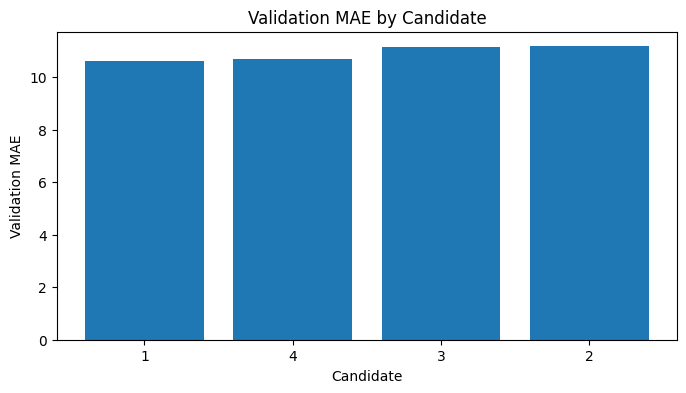

In [14]:
# 간단한 bar plot (후보별 검증 MAE)
plt.figure(figsize=(8, 4))
plt.bar(results_df_sorted["candidate"].astype(str), results_df_sorted["mae_val"])
plt.xlabel("Candidate")
plt.ylabel("Validation MAE")
plt.title("Validation MAE by Candidate")
plt.show()


## 8. 베스트 모델 정보 출력

In [15]:
best_row = results_df_sorted.iloc[0]
print("=== Best Candidate ===")
print("candidate:", best_row["candidate"])
print(f"VAL  MAE={best_row['mae_val']:.3f} | MAPE={best_row['mape_val']:.2f}% | SMAPE={best_row['smape_val']:.2f}%")
print(f"TEST MAE={best_row['mae_test']:.3f} | MAPE={best_row['mape_test']:.2f}% | SMAPE={best_row['smape_test']:.2f}%")
print("\nparams:")
for k, v in best_row["params"].items():
    print(f"  {k}: {v}")


=== Best Candidate ===
candidate: 1
VAL  MAE=10.615 | MAPE=94.99% | SMAPE=44.75%
TEST MAE=15.585 | MAPE=72.31% | SMAPE=23.78%

params:
  objective: poisson
  random_state: 42
  verbosity: -1
  n_estimators: 3000
  learning_rate: 0.02
  num_leaves: 31
  max_depth: 8
  min_child_samples: 128
  subsample: 0.65
  colsample_bytree: 0.65
  reg_alpha: 2.0
  reg_lambda: 2.0


실서비스 관점에서 Candidate 1 선택이 가장 합리적임  
->  Validation = “미래예측 성능”   
->  Test = “과거 데이터의 Holdout test”  
실전은 미래 성능이 더 중요하기 때문에  
Validation MAE 가장 낮은 Candidate 1이 베스트